In [225]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [226]:
n_epochs = 50   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 100    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/" # Data saving folder
PREPROCESS = False           # If False, skip quantum processing and load data from SAVE_PATH
# np.random.seed(0)           # Seed for NumPy random number generator
# tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [227]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [228]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [229]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [230]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save("q_train_images.npy", q_train_images)
    np.save("q_test_images.npy", q_test_images)

# Load pre-processed images
q_train_images = np.load("q_train_images.npy")
q_test_images = np.load("q_test_images.npy")

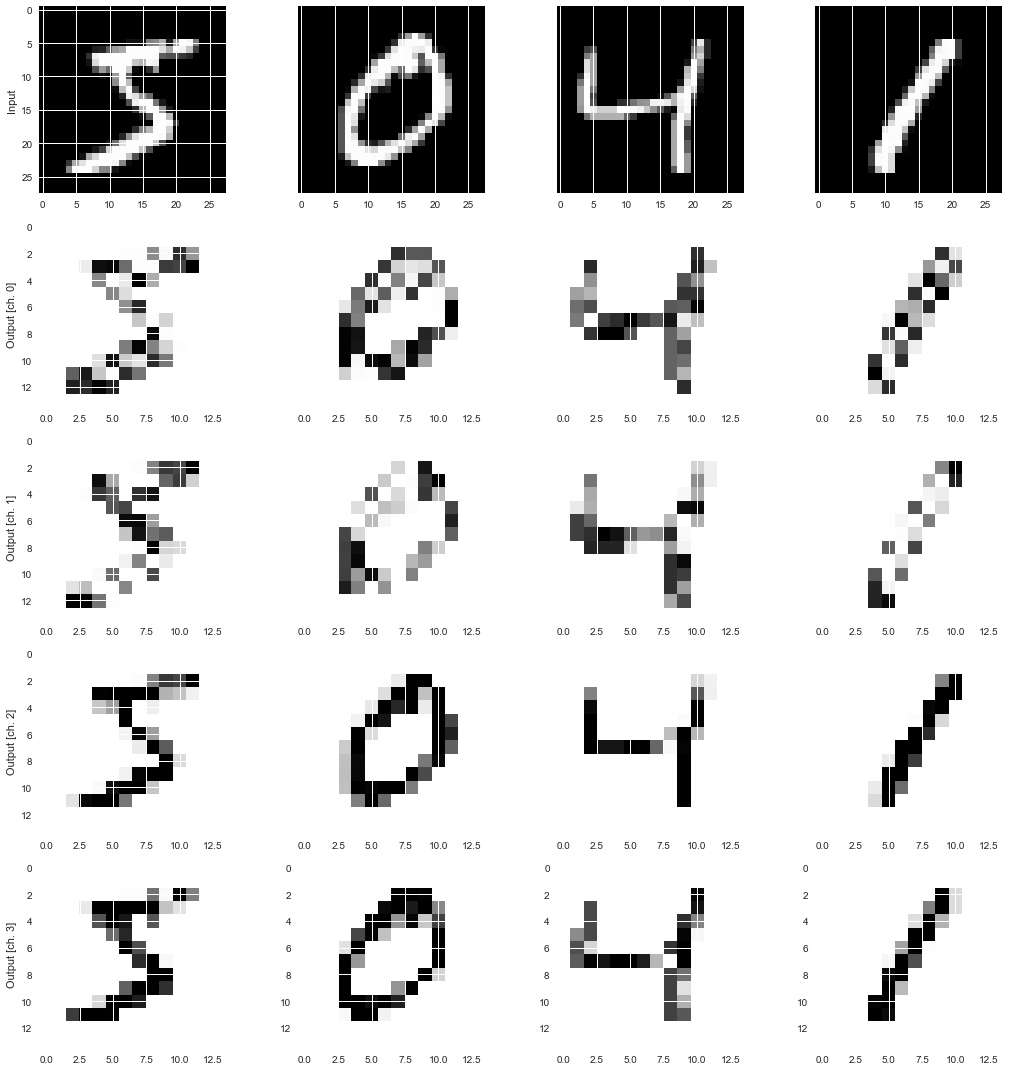

In [231]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(15, 15))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [232]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [233]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/50
25/25 - 0s - loss: 2.4892 - accuracy: 0.2200 - val_loss: 2.0079 - val_accuracy: 0.4667 - 295ms/epoch - 12ms/step
Epoch 2/50
25/25 - 0s - loss: 1.6262 - accuracy: 0.4700 - val_loss: 1.6874 - val_accuracy: 0.4333 - 79ms/epoch - 3ms/step
Epoch 3/50
25/25 - 0s - loss: 1.1125 - accuracy: 0.7600 - val_loss: 1.4176 - val_accuracy: 0.7333 - 71ms/epoch - 3ms/step
Epoch 4/50
25/25 - 0s - loss: 0.8120 - accuracy: 0.8600 - val_loss: 1.2343 - val_accuracy: 0.7667 - 64ms/epoch - 3ms/step
Epoch 5/50
25/25 - 0s - loss: 0.6228 - accuracy: 0.9100 - val_loss: 1.1082 - val_accuracy: 0.7333 - 62ms/epoch - 2ms/step
Epoch 6/50
25/25 - 0s - loss: 0.4959 - accuracy: 0.9500 - val_loss: 1.0854 - val_accuracy: 0.8000 - 68ms/epoch - 3ms/step
Epoch 7/50
25/25 - 0s - loss: 0.4004 - accuracy: 0.9600 - val_loss: 0.9145 - val_accuracy: 0.8333 - 62ms/epoch - 2ms/step
Epoch 8/50
25/25 - 0s - loss: 0.3106 - accuracy: 0.9800 - val_loss: 0.9375 - val_accuracy: 0.8000 - 59ms/epoch - 2ms/step
Epoch 9/50
25/25 - 0s 

In [234]:
c_model = MyModel()
c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/50
25/25 - 0s - loss: 2.1504 - accuracy: 0.2600 - val_loss: 1.9782 - val_accuracy: 0.4333 - 260ms/epoch - 10ms/step
Epoch 2/50
25/25 - 0s - loss: 1.5999 - accuracy: 0.6000 - val_loss: 1.7001 - val_accuracy: 0.5333 - 53ms/epoch - 2ms/step
Epoch 3/50
25/25 - 0s - loss: 1.2083 - accuracy: 0.8400 - val_loss: 1.4910 - val_accuracy: 0.7000 - 58ms/epoch - 2ms/step
Epoch 4/50
25/25 - 0s - loss: 0.9573 - accuracy: 0.9100 - val_loss: 1.3662 - val_accuracy: 0.7333 - 56ms/epoch - 2ms/step
Epoch 5/50
25/25 - 0s - loss: 0.7639 - accuracy: 0.9500 - val_loss: 1.2452 - val_accuracy: 0.7000 - 69ms/epoch - 3ms/step
Epoch 6/50
25/25 - 0s - loss: 0.6337 - accuracy: 0.9800 - val_loss: 1.1723 - val_accuracy: 0.7000 - 71ms/epoch - 3ms/step
Epoch 7/50
25/25 - 0s - loss: 0.5295 - accuracy: 0.9800 - val_loss: 1.1215 - val_accuracy: 0.7333 - 53ms/epoch - 2ms/step
Epoch 8/50
25/25 - 0s - loss: 0.4489 - accuracy: 0.9800 - val_loss: 1.0798 - val_accuracy: 0.7000 - 55ms/epoch - 2ms/step
Epoch 9/50
25/25 - 0s 

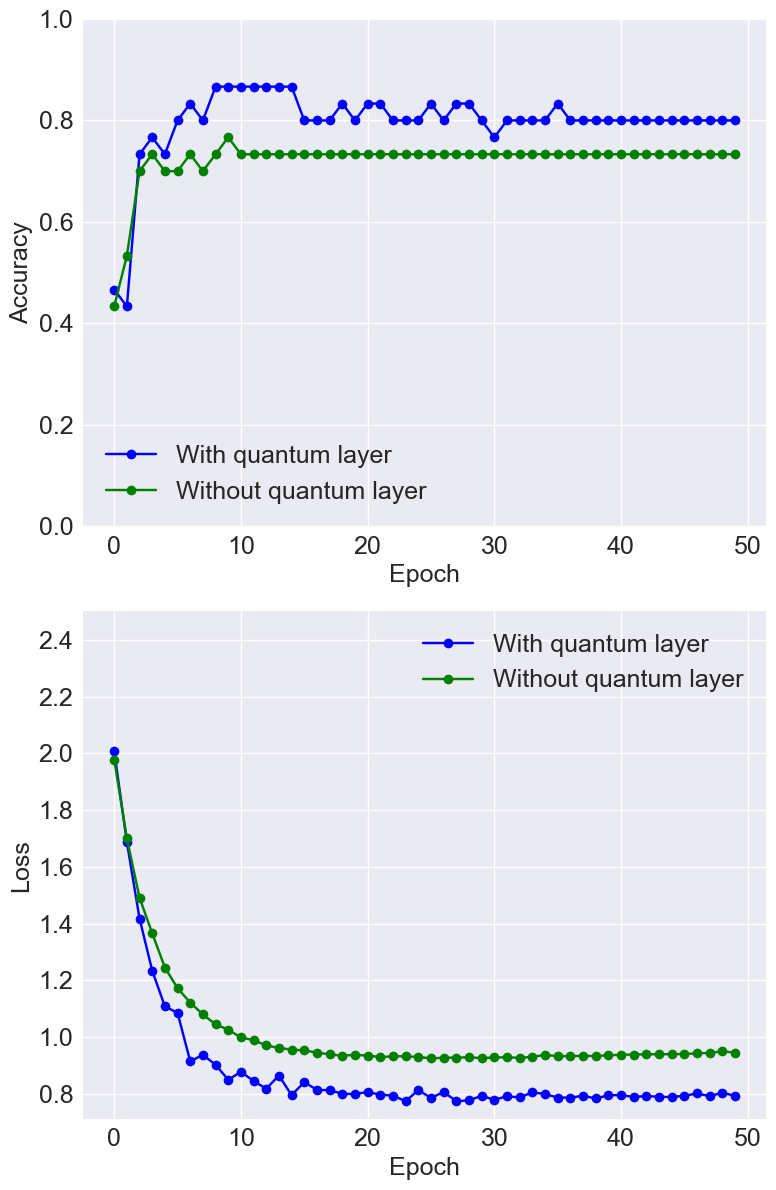

In [254]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 36 
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy", fontsize=18)
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch", fontsize=18)
ax1.legend(prop={'size': 18})
ax1.tick_params(axis="x", labelsize=18)
ax1.tick_params(axis="y", labelsize=18)


ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss", fontsize=18)
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch", fontsize=18)
ax2.legend(prop={'size': 18})
ax2.tick_params(axis="x", labelsize=18)
ax2.tick_params(axis="y", labelsize=18)

plt.tight_layout()
plt.show()

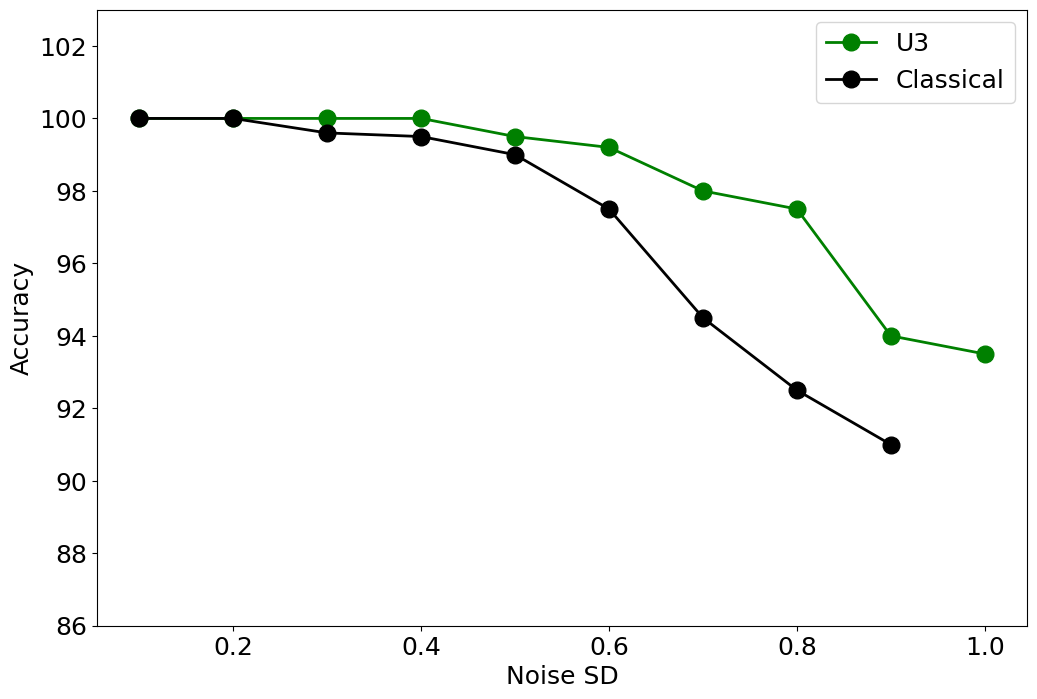

In [251]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('default')
x1 = [100,100,100,100,99.5,99.2,98,97.5,94.0,93.5]
x2 = [100,100,99.6,99.5,99,97.5,94.5,92.5,91]
y1 = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
y2 = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
plt.figure(figsize=(12, 8))

plt.plot(y1, x1, 'go-', label='U3', linewidth=2, markersize=12)
plt.plot(y2, x2, 'ko-', label='Classical', linewidth=2, markersize=12)
plt.xlabel('Noise SD', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend(prop={'size': 18})
plt.ylim(86, 103)
plt.tick_params(axis='both', labelsize=18)
plt.show()